In [1]:
import local_models.local_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
import sklearn.svm
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import joblib
import functools
import itertools
import collections
import local_models.loggin
import local_models.TLS_models
import local_models.utils
from local_models.TLS_models import LinearRegression, QuadraticRegression, SphericalRegression, LinearODR

logger = logging.getLogger(__name__)

np.random.seed(1)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [2]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]
import cycler
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
#colorblind cycle thx @ https://gist.github.com/thriveth/8560036
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', CB_color_cycle)

In [3]:
BANDWIDTH = 0.8
C = 5.
n = 200
noise=.06
SEED = 1
np.random.seed(SEED)
KERNEL=local_models.local_models.GaussianKernel
noisy_moons, c = sklearn.datasets.make_moons(n_samples=n, noise=noise)
noisy_moons = noisy_moons/np.std(noisy_moons, axis=0)
noisy_moons -= np.mean(noisy_moons, axis=0)

In [4]:
RUN =38
project_dir = "../data/local_svm_moons_{:03d}".format(RUN)
os.makedirs(project_dir, exist_ok=1)

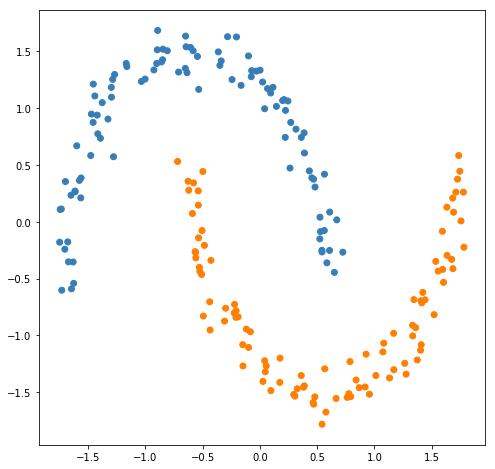

In [5]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=[CB_color_cycle[i] for i in c])
plt.show()

In [6]:
class ScaledGaussianKernel(local_models.local_models.GaussianKernel):
    def __init__(self, bandwidth=None, k=None, s=1.):
        super().__init__(bandwidth, k)
        self.s = s
    def __call__(self, x):
        return super().__call__(x)*self.s
    def d(self, x):
        return super().d(x)*self.s

In [7]:
help(sklearn.svm.LinearSVC)

Help on class LinearSVC in module sklearn.svm._classes:

class LinearSVC(sklearn.base.BaseEstimator, sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin)
 |  Linear Support Vector Classification.
 |  
 |  Similar to SVC with parameter kernel='linear', but implemented in terms of
 |  liblinear rather than libsvm, so it has more flexibility in the choice of
 |  penalties and loss functions and should scale better to large numbers of
 |  samples.
 |  
 |  This class supports both dense and sparse input and the multiclass support
 |  is handled according to a one-vs-the-rest scheme.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  penalty : str, 'l1' or 'l2' (default='l2')
 |      Specifies the norm used in the penalization. The 'l2'
 |      penalty is the standard used in SVC. The 'l1' leads to ``coef_``
 |      vectors that are sparse.
 |  
 |  loss : str, 'hinge' or 'squared_hinge' (default=

In [8]:
#kernel = ScaledGaussianKernel(bandwidth=1.,s=1.)
#kernel = local_models.local_models.GaussianKernel(bandwidth="knn", k=12)
kernel = local_models.local_models.GaussianKernel(bandwidth=BANDWIDTH)
#LinearSVC does not currently support sample_weight.  The new version circa early december 2019 should.
model = sklearn.svm.LinearSVC(C=C, loss="hinge")
#model = sklearn.svm.SVC(C=1e3,kernel="linear")
linear_models = local_models.local_models.LocalModels(model)
linear_models.fit(noisy_moons,c)

In [9]:
RANGE_PCT = 0.2
grid_N = 20
data = noisy_moons
min_data, max_data = np.min(data, axis=0), np.max(data, axis=0)
data_range = max_data - min_data
how_much_to_include_outside_range = RANGE_PCT*data_range
data_ranges = np.stack((min_data - how_much_to_include_outside_range, max_data + how_much_to_include_outside_range)).T
data_step = (data_ranges[:,1] - data_ranges[:,0])/grid_N
grid_limits = tuple(map(lambda i: slice(data_ranges[i][0], data_ranges[i][1], grid_N*1j), range(data_ranges.shape[0])))
g = np.mgrid[grid_limits]
xx = np.vstack(map(np.ravel, g)).T
g_like_shape = [-1] + list(g.shape[1:])

In [10]:
np.sum(g.transpose(1,2,0)**2,axis=-1)

array([[12.15363109, 10.9562434 ,  9.88912732,  8.95228285,  8.14571   ,
         7.46940877,  6.92337915,  6.50762114,  6.22213475,  6.06691997,
         6.04197681,  6.14730526,  6.38290532,  6.748777  ,  7.2449203 ,
         7.87133521,  8.62802173,  9.51497987, 10.53220962, 11.67971099],
       [10.94236795,  9.74498026,  8.67786418,  7.74101972,  6.93444687,
         6.25814563,  5.71211601,  5.296358  ,  5.01087161,  4.85565683,
         4.83071367,  4.93604212,  5.17164218,  5.53751386,  6.03365716,
         6.66007207,  7.41675859,  8.30371673,  9.32094648, 10.46844785],
       [ 9.86662142,  8.66923372,  7.60211764,  6.66527318,  5.85870033,
         5.18239909,  4.63636947,  4.22061147,  3.93512507,  3.7799103 ,
         3.75496713,  3.86029558,  4.09589565,  4.46176733,  4.95791062,
         5.58432553,  6.34101206,  7.22797019,  8.24519995,  9.39270131],
       [ 8.92639148,  7.72900379,  6.66188771,  5.72504324,  4.91847039,
         4.24216916,  3.69613954,  3.28038153,  

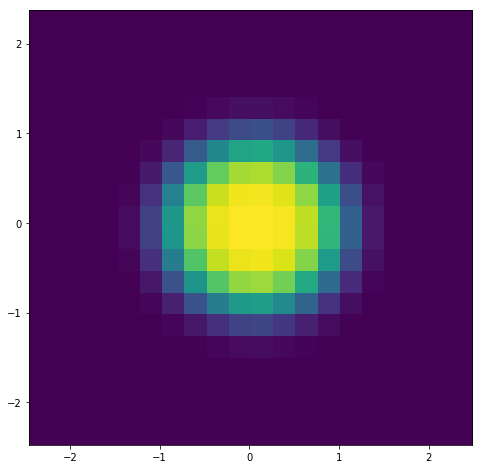

In [11]:
plt.imshow(kernel(np.sum(g.transpose(1,2,0)**2,axis=-1)), extent=data_ranges.reshape(-1))

In [12]:
xx_linear_params, the_models = linear_models.transform(xx,r=kernel.support_radius(),weighted=True,kernel=kernel, return_models=True)
xx_linear_params.shape

(400, 3)

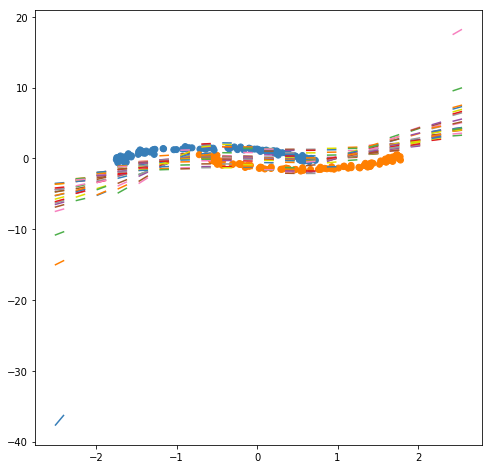

In [13]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=[CB_color_cycle[i] for i in c])
span = np.linspace(-0.05,0.05,3)
for i in range(xx.shape[0]):
    #x,y = noisy_moons[i]
    plt.plot(span + xx[i,0], (-xx_linear_params[i,2]-xx_linear_params[i,0]*(span+xx[i,0]))/xx_linear_params[i,1])
plt.show()

In [14]:
#perps = np.linalg.solve(xx_linear_params[:,1:2].reshape(-1,1,1), -xx_linear_params[:,0:1])
perps = np.stack((-xx_linear_params[:,1], xx_linear_params[:,0]),axis=-1)

In [15]:
#perps = np.stack((np.ones(perps.shape[0]), perps[:,0]), axis=-1)

In [16]:
#bases=xx_linear_params[:,:2].reshape(400,1,2)/np.sqrt(np.sum(xx_linear_params[:,:2]**2,axis=-1)).reshape(400,1,1)
bases=perps[:,:2].reshape(400,1,2)/np.sqrt(np.sum(perps[:,:2]**2,axis=-1)).reshape(400,1,1)

In [17]:
projected_xx = local_models.utils.linear_project_pointwise_bases(xx, bases,# perps.reshape(400,1,2),
            np.stack((np.zeros(xx_linear_params[:,2].shape), -xx_linear_params[:,2]/xx_linear_params[:,1]),axis=-1))

In [18]:
def perp2d(v):
    a,b = v
    return np.array((-b,a))/np.linalg.norm([a,b])

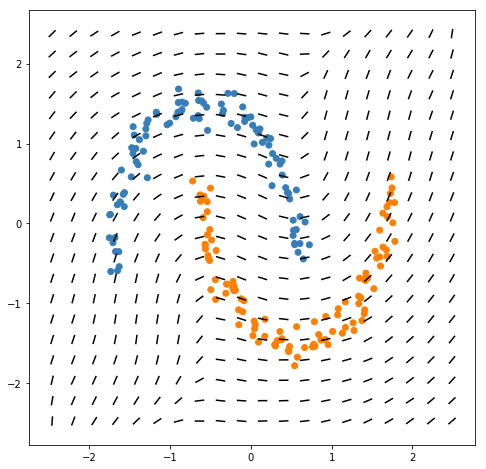

In [19]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=[CB_color_cycle[i] for i in c])
span = np.linspace(-0.05,0.05,3)
for i in range(xx.shape[0]):
    #x,y = noisy_moons[i]
    line = np.einsum("i,j->ij", span, perp2d(xx_linear_params[i,:2])) + xx[i]
    plt.plot(line[:,0], line[:,1], c='k')
    #plt.plot(projected_xx[i,0] + span, (-xx_linear_params[i,2]-xx_linear_params[i,0]*(span+projected_xx[i,0]))/xx_linear_params[i,1])
plt.show()

In [20]:
xx_linear_params.shape

(400, 3)

In [21]:
weird = np.argmax(np.sum((projected_xx-xx)**2, axis=1))
weird

380

In [22]:
iz,dz = linear_models.index.query_radius(xx[weird:weird+1], r=kernel.support_radius(), return_distance=True)

In [23]:
dz

array([array([2.98418697, 2.89961867, 2.92798647, 2.98088053, 3.27285317,
       4.67127413, 4.6171474 , 3.77150807, 3.15453883, 4.54486938,
       3.29676473, 3.40676662, 3.61476688, 3.66110982, 3.60973941,
       4.75091642, 3.420828  , 3.18316465, 4.54768607, 3.76386109,
       4.75934151, 3.18700103, 3.22333706, 3.73417912, 3.73883138,
       3.22450866, 3.63814252, 3.13995519, 4.63456613, 3.02313329,
       4.82017825, 3.81930967, 4.95333227, 4.94652007, 3.83580859,
       4.0036295 , 3.9954974 , 4.95972747, 4.86227346, 4.93295838,
       4.16492865, 5.05345361, 4.95888459, 4.93796469, 4.95897389,
       4.21029985, 4.08733909, 4.15302342, 4.17457005, 4.39537229,
       4.84531015, 5.00828604, 5.15730304, 5.03668991, 5.07931117,
       5.17536757, 5.18976719, 5.23008419, 5.09648938, 5.31756769,
       4.531881  , 5.26408663, 5.23430766, 5.39795363, 4.73067609,
       5.20374734, 4.4487517 , 5.32358329, 5.14244395, 4.94776562,
       5.35889281, 4.7829189 , 5.0261579 , 5.30464741, 

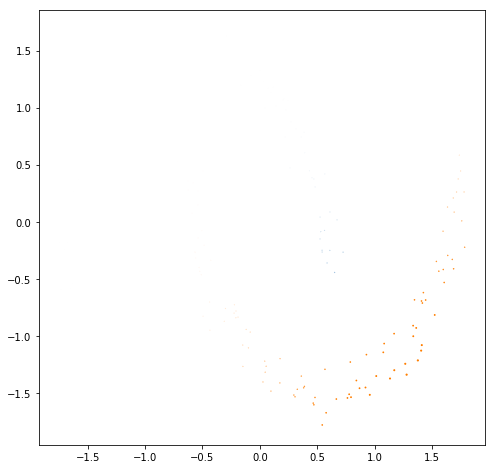

In [24]:
plt.scatter(noisy_moons[iz[0]][:,0], noisy_moons[iz[0]][:,1], c=[CB_color_cycle[i] for i in c[iz[0]]], s=30*kernel(dz[0]))

In [25]:
xx[weird]

array([ 2.48899896, -2.47342972])

In [26]:
projected_xx[weird]

array([-0.34261055,  0.74895028])

In [27]:
xx_linear_params[weird]

array([ 0.30808371, -0.35060017,  0.36813483])

In [28]:
#testfit_model = sklearn.svm.SVC(C=0.0001,kernel="linear",verbose=True)
testfit_model = sklearn.base.clone(model)

In [29]:
dz[0]

array([2.98418697, 2.89961867, 2.92798647, 2.98088053, 3.27285317,
       4.67127413, 4.6171474 , 3.77150807, 3.15453883, 4.54486938,
       3.29676473, 3.40676662, 3.61476688, 3.66110982, 3.60973941,
       4.75091642, 3.420828  , 3.18316465, 4.54768607, 3.76386109,
       4.75934151, 3.18700103, 3.22333706, 3.73417912, 3.73883138,
       3.22450866, 3.63814252, 3.13995519, 4.63456613, 3.02313329,
       4.82017825, 3.81930967, 4.95333227, 4.94652007, 3.83580859,
       4.0036295 , 3.9954974 , 4.95972747, 4.86227346, 4.93295838,
       4.16492865, 5.05345361, 4.95888459, 4.93796469, 4.95897389,
       4.21029985, 4.08733909, 4.15302342, 4.17457005, 4.39537229,
       4.84531015, 5.00828604, 5.15730304, 5.03668991, 5.07931117,
       5.17536757, 5.18976719, 5.23008419, 5.09648938, 5.31756769,
       4.531881  , 5.26408663, 5.23430766, 5.39795363, 4.73067609,
       5.20374734, 4.4487517 , 5.32358329, 5.14244395, 4.94776562,
       5.35889281, 4.7829189 , 5.0261579 , 5.30464741, 5.11599

In [30]:
inverse_iz = np.empty_like(iz[0])
inverse_iz[iz[0]] = np.arange(iz[0].shape[0])

In [31]:
inverse_iz

array([ 68,  90,  98,  47, 158, 192,  30, 154, 177, 128, 133, 171, 164,
        39,  31,   4, 140,  94, 102,  70,  81, 186,  84,   5, 172, 113,
        97, 163, 187, 180,  92, 120, 195, 145, 127,   6, 129,  63,  73,
       132,  34,  36, 162, 181,  86, 184,   7,  89, 160,   8,   9,  10,
        11,  80,  66, 148, 146,  35, 198, 104,  12,  85,  62,  87, 175,
       159,   0,  46,  91,  61,  93,  42, 151, 124, 125,  13, 199,  14,
        15,  16, 131,  37,  52,  17, 193, 182,  51,   2, 153,  88,  18,
        96, 112, 152, 115,  48, 194, 196, 137, 139,  55, 176,  32, 114,
       156,  67,  44, 118, 167,  19, 150, 121,  53,  74,  76, 130,  41,
        29,  64,  82,  58,  20, 141, 142, 143,  43, 144, 110, 111, 169,
       173,  33, 149,  49,  21, 191,  22, 179, 116,  40, 117, 103,  23,
       157,  95, 166,  99, 119,  24,  50,  69, 189,  56,  71, 188, 161,
       122,  72, 123,   3, 183, 170,  25,  26, 126, 190,  75,  27, 155,
        77, 165,  78,  79, 168, 197, 105,  38,  28,  65,  83, 13

In [32]:
dz[0][inverse_iz]

array([5.14244395, 4.90515764, 4.55900382, 4.15302342, 2.32911859,
       3.01100961, 4.82017825, 2.82505046, 4.32915204, 1.68040602,
       1.99302077, 3.72660301, 3.07521538, 4.93295838, 3.81930967,
       3.27285317, 1.80645587, 4.54323208, 2.71675563, 5.35889281,
       5.09186877, 3.57286883, 4.88728842, 4.67127413, 4.36006033,
       2.03761952, 4.54805005, 4.21651635, 2.79987905, 4.20363955,
       4.96368967, 1.94101553, 2.84215645, 2.07101057, 1.91821655,
       4.6171474 , 1.9114031 , 5.39795363, 5.30464741, 1.9432215 ,
       3.83580859, 3.9954974 , 2.35787305, 3.51081832, 5.16783501,
       3.87617806, 3.77150807, 4.70813715, 2.33945905, 3.15453883,
       4.54486938, 3.29676473, 3.40676662, 4.90941001, 4.4487517 ,
       2.13706813, 2.08206511, 4.0036295 , 3.14756064, 2.58931764,
       3.61476688, 5.29885925, 5.23430766, 4.95050676, 3.69245282,
       2.94340855, 2.98418697, 4.08733909, 5.06365777, 5.26408663,
       4.96032505, 4.95888459, 2.24246098, 1.91276767, 1.73393

In [33]:
iz[0]

array([ 66, 191,  87, 159,  15,  23,  35,  46,  49,  50,  51,  52,  60,
        75,  77,  78,  79,  83,  90, 109, 121, 134, 136, 142, 148, 162,
       163, 167, 177, 117,   6,  14, 102, 131,  40,  57,  41,  81, 176,
        13, 139, 116,  71, 125, 106, 185,  67,   3,  95, 133, 149,  86,
        82, 112, 194, 100, 152, 190, 120, 197, 199,  69,  62,  37, 118,
       178,  54, 105,   0, 150,  19, 153, 157,  38, 113, 166, 114, 169,
       171, 172,  53,  20, 119, 179,  22,  61,  44,  63,  89,  47,   1,
        68,  30,  70,  17, 144,  91,  26,   2, 146, 195, 189,  18, 141,
        59, 175, 183, 192, 196, 198, 127, 128,  92,  25, 103,  94, 138,
       140, 107, 147,  31, 111, 156, 158,  73,  74, 164,  34,   9,  36,
       115,  80,  39,  10, 180, 181, 182,  98, 184,  99,  16, 122, 123,
       124, 126,  33,  56, 187,  55, 132, 110,  72,  93,  88,   7, 168,
       104, 143,   4,  65,  48, 155,  42,  27,  12, 170, 145, 108, 173,
       129, 161,  11,  24, 130, 188,  64, 101,   8, 186, 137,  2

In [34]:
testfit_model.fit(noisy_moons[iz[0]], c[iz[0]], sample_weight=dz[0])

LinearSVC(C=5.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [35]:
def line(coef, intercept, x):
    return x, (x*coef[0] + intercept)/(-coef[1])

In [36]:
testfit_model.coef_

array([[ 0.78446927, -1.59394443]])

In [37]:
testfit_model.coef_[0,1]/testfit_model.coef_[0,0]

-2.031876187574947

In [38]:
testfit_model.intercept_

array([0.02129441])

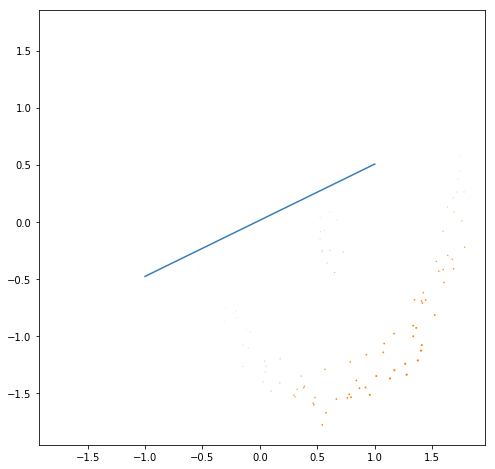

In [39]:
plt.scatter(noisy_moons[iz[0]][:,0], noisy_moons[iz[0]][:,1], c=[CB_color_cycle[i] for i in c[iz[0]]], s=30*kernel(dz[0]))
plt.plot(*line(testfit_model.coef_[0], testfit_model.intercept_, np.array([-1,1])))

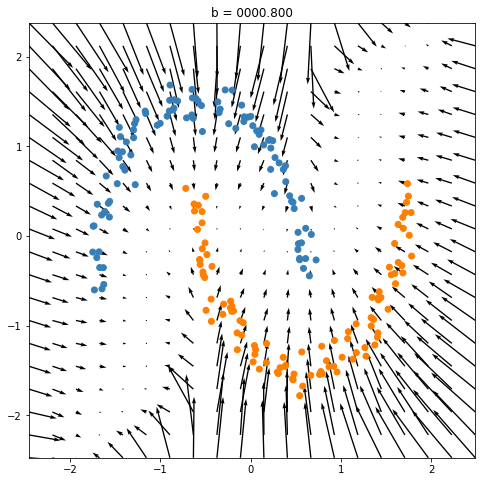

In [40]:
changes = projected_xx - xx
#pts = np.array([[1.8, 0.1]])
pts = xx
plt.quiver(xx[:,0], xx[:,1], changes[:,0], changes[:,1], scale=30.)
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=[CB_color_cycle[i] for i in c])
plt.xlim(*data_ranges[0])
plt.ylim(*data_ranges[1])
plt.title("b = {:08.03f}".format(BANDWIDTH))

span = np.linspace(0.05,0.05,10)
pts_params = linear_models.transform(pts, r=kernel.support_radius(), weighted=True, kernel=kernel)
#for i in range(pts.shape[0]):
#    x,y = pts[i]
#    plt.plot(span + x, (1-pts_params[i,0]*(span+x))/pts_params[i,1])
plt.savefig(os.path.join(project_dir, "b_{:08.03f}.png".format(BANDWIDTH)))
plt.show()

In [41]:
def linear_reject_pointwise_bases(x, bases, mean=0):
    x = x - mean #mean center everything
    projection = local_models.utils.linear_project_pointwise_bases(x, bases)
    rejection = x - projection
    rejection = rejection + mean #re-add the mean in
    return rejection
def constrained_rejection(x, v1, constraint, mean=0):
    ''' reject x from v1 constrained to the constraint direction '''
    x = x-mean
    magnitude = np.sum(x*v1, axis=1, keepdims=True)/np.sum(constraint*v1, axis=1, keepdims=True)
    return -magnitude*constraint + mean + x

def scms(X, lm, kernel, iters=30, constraint_space=None, return_params=False, failure_delta=None):
    #all_failures = []
    
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=iters, tag="local_svm_shifter")

    if failure_delta is None:
        failure_delta = np.average(lm.index.query(X, k=2)[0][:,1])*1e2
    #original_X = X
    for i in range(iters):
        with timelog:
            X = np.copy(X)
            Xrange = np.arange(X.shape[0])
            params = lm.transform(X, r=kernel.support_radius(), weighted=True,
                kernel=kernel)
            logger.info("svm_params_transformed!")
            normalized_params = params/np.sqrt(np.sum(params[:,:X.shape[1]]**2,axis=-1,keepdims=True))
            normals = normalized_params[:,:X.shape[1]]
            intercepts = normalized_params[:,X.shape[1]]
            biggest_normal_component = np.argmax(normals, axis=1)
            biggest_normal_component_indices = np.stack((Xrange, biggest_normal_component))
            biggest_normal_component_indices = tuple(map(tuple, biggest_normal_component_indices))

            plane_pt_component = -intercepts/normalized_params[biggest_normal_component_indices]
            plane_pts = np.zeros(normals.shape)
            plane_pts[biggest_normal_component_indices] = plane_pt_component

            normals = normals.reshape(X.shape[0], 1, X.shape[1])
            if constraint_space is None:
                new_X = linear_reject_pointwise_bases(X, normals, plane_pts)
            else:
                new_X = constrained_rejection(X, normals[:,0,:], constraint_space[0][:,0,:], plane_pts)

            failures = np.sqrt(np.sum((new_X-X)**2, axis=1)) > failure_delta
            successes = np.logical_not(failures)
            X[successes] = new_X[successes]
            #if constraint_space is not None:
            #    X[successes] = local_models.utils.linear_project_pointwise_bases(X[successes], constraint_space[0][successes], constraint_space[1][successes])

            if return_params:
                yield X, successes, normals
            else:
                yield X, successes

def exhaust(gen):
    def exhauster(*args, **kwargs):
        for _ in gen(*args, **kwargs): pass
        return _
    return exhauster

import tempfile
import time
def scms_parallel_sharedmem(X, lm, kernel, iters=30, constraint_space=None, return_params=False, failure_delta=None, batch_size=100):
    batches = (np.array([0, batch_size]) + batch_size*i for i in range(int(np.ceil(X.shape[0]/batch_size))))
    with tempfile.NamedTemporaryFile(dir="/dev/shm") as shared_X_ramspace, tempfile.NamedTemporaryFile(dir="/dev/shm") as shared_constraint0_ramspace, tempfile.NamedTemporaryFile(dir="/dev/shm") as shared_constraint1_ramspace:
        shared_X = np.memmap(shared_X_ramspace, dtype=X.dtype,
                   shape=X.shape, mode='w+')
        shared_X[:] = X[:]
        if constraint_space is not None:
            shared_constraint_space0 = np.memmap(shared_constraint0_ramspace, dtype=constraint_space[0].dtype,
                   shape=constraint_space[0].shape, mode='w+')
            shared_constraint_space1 = np.memmap(shared_constraint1_ramspace, dtype=constraint_space[1].dtype,
                   shape=constraint_space[1].shape, mode='w+')
            shared_constraint_space0[:] = constraint_space[0][:]
            shared_constraint_space1[:] = constraint_space[1][:]
            constraint_space = (shared_constraint_space0, shared_constraint_space1)
        parallel_sols = joblib.Parallel(n_jobs=12)(joblib.delayed(exhaust(scms))(
            shared_X[slice(*batch)], lm, kernel, iters, 
            None if constraint_space is None else tuple(map(lambda c: c[slice(*batch)], constraint_space)), 
            return_params, failure_delta)
            for batch in batches)
    res = tuple(map(functools.partial(np.concatenate, axis=0), zip(*parallel_sols)))
    yield res
    
def scms_parallel(X, lm, kernel, iters=30, constraint_space=None, return_params=False, failure_delta=None, batch_size=100):
    batches = (np.array([0, batch_size]) + batch_size*i for i in range(int(np.ceil(X.shape[0]/batch_size))))
    parallel_sols = joblib.Parallel()(joblib.delayed(exhaust(scms))(
        X[slice(*batch)], lm, kernel, iters, 
        None if constraint_space is None else tuple(map(lambda c: c[slice(*batch)], constraint_space)), 
        return_params, failure_delta)
        for batch in batches)
    res = tuple(map(functools.partial(np.concatenate, axis=0), zip(*parallel_sols)))
    yield res

import traceback
import collections
def orthogonal_project_scms(X, lm, kernel, scms_iters=30, newtons_iters=30, alpha=1e-2, return_everything=False, parallel=False, sharedmem=True):
    #1. do scms to get *a* point on the surface, y
    #2. get the tangent plane at y
    scms_method = scms_parallel_sharedmem if (parallel and sharedmem) else (scms_parallel if parallel else scms)

    newton_timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=newtons_iters, tag="local_svm_newton")
    shifter_timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=scms_iters, tag="local_svm_shift")

    logger.info("svm shifting!")
    if return_everything:
        everything = collections.defaultdict(list)
    shifter = scms_method(X,lm,kernel,iters=scms_iters,return_params=True)
    for y, successes, normals in shifter:
        with shifter_timelog:
            if return_everything:
                everything[("ortho_newtons", -1)].append((y, successes, normals))
    shifter_timelog.i=0
    logger.info("svm shifted!")
    X = X[successes]
    y = y[successes]
    normals = normals[successes]
    Xy = y-X
    normalized_Xy = (Xy)/np.sqrt(np.sum(Xy**2,axis=1,keepdims=True))
    normalized_Xy = np.expand_dims(normalized_Xy, 1)
    #print("shapes", normalized_Xy.shape, normals.shape)
    surface_normal_aligned_Xy = normalized_Xy * np.sign(np.sum(normalized_Xy*normals, axis=-1, keepdims=True))
    constraint_vec = normalized_Xy
    #3. do scms while projecting along some convex combo of the line passing thru x and y, and 
    #   the line passing through x and along the normal vector to the tangent plane in 2 to get y'
    #4. y <- y'
    #5. GOTO 2
    for i in range(newtons_iters):
        with newton_timelog:
            try:
                constrained_shifter = scms_method(X,lm,kernel,iters=scms_iters,return_params=True,constraint_space=(constraint_vec, X))        
                for y, successes, normals in constrained_shifter:
                    with shifter_timelog:
                        if return_everything:
                            everything[("ortho_newtons", i)].append((y, successes, normals))
                            
                #check the results
                shifter = scms_method(y,lm,kernel,iters=scms_iters,return_params=True)
                for y, successes, normals in shifter:
                    with shifter_timelog:
                        if return_everything:
                            everything[("proj_newtons", i)].append((y, successes, normals))
                shifter_timelog.i=0
                #X = X[successes]
                #y = y[successes]
                #normals = normals[successes]
                Xy = y-X
                normalized_Xy = (Xy)/np.sqrt(np.sum(Xy**2,axis=1,keepdims=True))
                normalized_Xy = np.expand_dims(normalized_Xy, 1)
                #print("shapes", normalized_Xy.shape, normals.shape)
                surface_normal_aligned_Xy = normalized_Xy * np.sign(np.sum(normalized_Xy*normals, axis=-1, keepdims=True))
                constraint_vec = surface_normal_aligned_Xy*(1-alpha) + normals*alpha
                constraint_vec = constraint_vec/np.sqrt(np.sum(constraint_vec**2, axis=-1, keepdims=True))
                print("constraint shape", constraint_vec.shape)
            except:
                logger.info(traceback.print_exc())
                break
    if return_everything:
        return everything
    return X, y, normals  

In [42]:
start = time.time()
test = orthogonal_project_scms(noisy_moons, linear_models, kernel,
    newtons_iters=30, scms_iters=30,
    return_everything=True, parallel=True, alpha=0.5)
stop = time.time()
print((stop-start)/60)

constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
constraint shape (200, 1, 2)
3.9047502875328064


In [43]:
project_dir

'../data/local_svm_moons_038'

In [44]:
scmsnewtondir = os.path.join(project_dir, "scms_orthogonal")
os.makedirs(scmsnewtondir, exist_ok=1)

In [45]:
print(noisy_moons.shape)

(200, 2)


In [46]:
data_ranges[1]

array([-2.47342972,  2.37569663])

In [47]:
X = noisy_moons
targets = c
data_range_1_avg = np.average(data_ranges[1])
data_range_0_rng = np.diff(data_ranges[0])
data_ranges[1] = np.concatenate([data_range_1_avg - data_range_0_rng/2, data_range_1_avg + data_range_0_rng/2])
for newton in sorted(test,key=lambda x:x[1]):
    newt_type, newt_i = newton
    print("plting newton {}".format(newton))
    for i in range(len(test[newton])):
        y, successes, normals = test[newton][i]
        print(list(map(lambda z: z.shape, (X, y, successes, normals))))
        fig = plt.figure()
        plt.scatter(y[:,0], y[:,1], s=2, c='r',zorder=9999)
        for j in range(X.shape[0]):
            plt.plot(np.stack((X[j,0],y[j,0])), np.stack((X[j,1],y[j,1])), c='k')
        plt.scatter(X[:,0], X[:,1],c=[CB_color_cycle[i] for i in targets],zorder=10000)
        plt.xlim(*data_ranges[0])
        plt.ylim(*data_ranges[1])
        plt.axis("off")
        plt.title("iteration: {}.{:05d}.{:05d}".format(newt_type, newt_i, i))
        plt.savefig(os.path.join(scmsnewtondir, "svc_moons_{}.{:05d}.{:05d}.png".format(newt_type, newt_i ,i)),
            bbox_inches="tight")
        plt.close(fig)
    X = X[successes]
    targets = targets[successes]

plting newton ('ortho_newtons', -1)
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton ('proj_newtons', 0)
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton ('ortho_newtons', 0)
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton ('proj_newtons', 1)
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton ('ortho_newtons', 1)
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton ('ortho_newtons', 2)
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton ('proj_newtons', 2)
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton ('ortho_newtons', 3)
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton ('proj_newtons', 3)
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton ('proj_newtons', 4)
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton ('ortho_newtons', 4)
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton ('proj_newtons', 5)
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plting newton ('ortho_newtons', 5)
[(200, 2), (200, 2), (200,), (200, 1, 2)]
plti

(-2.4567817357214246,
 2.488998956089655,
 -2.5217568910425685,
 2.424023800768511)

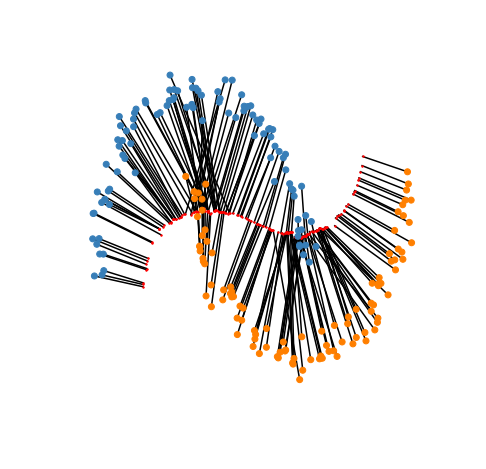

In [48]:
first_newton = test[("ortho_newtons",-1)]
y, successes, normals = first_newton[-1]
fig = plt.figure()
plt.scatter(y[:,0], y[:,1], s=2, c='r',zorder=9999)
for j in range(X.shape[0]):
    plt.plot(np.stack((X[j,0],y[j,0])), np.stack((X[j,1],y[j,1])), c='k')
plt.scatter(X[:,0], X[:,1],c=[CB_color_cycle[i] for i in targets],zorder=10000)
plt.xlim(*data_ranges[0])
plt.ylim(*data_ranges[1])
plt.axis('off')

In [49]:
len(test)

61

(-2.4567817357214246,
 2.488998956089655,
 -2.5217568910425685,
 2.424023800768511)

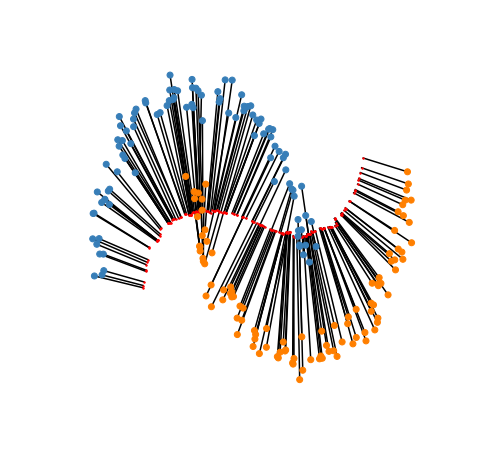

In [50]:
last_newton = test["ortho_newtons", 29]
y, successes, normals = last_newton[-1]
fig = plt.figure()
plt.scatter(y[:,0], y[:,1], s=2, c='r',zorder=9999)
for j in range(X.shape[0]):
    plt.plot(np.stack((X[j,0],y[j,0])), np.stack((X[j,1],y[j,1])), c='k')
plt.scatter(X[:,0], X[:,1],c=[CB_color_cycle[i] for i in targets],zorder=10000)
plt.xlim(*data_ranges[0])
plt.ylim(*data_ranges[1])
plt.axis('off')

In [51]:
data_ranges

array([[-2.45678174,  2.48899896],
       [-2.52175689,  2.4240238 ]])

In [52]:
dense_grid_N = 100
dense_grid_step = ((data_ranges[:,1] - data_ranges[:,0])/dense_grid_N)
dense_grid_limits = tuple(map(lambda i: slice(data_ranges[i][0], data_ranges[i][1], dense_grid_N*1j), range(data_ranges.shape[0])))
dense_grid = np.mgrid[dense_grid_limits]
dense_grid_X = np.vstack(map(np.ravel, dense_grid)).T
dense_grid_like_shape = [-1] + list(dense_grid.shape[1:])

In [53]:
dense_grid.shape

(2, 100, 100)

In [54]:
with joblib.parallel_backend("loky", n_jobs=4):
    start = time.time()
    grid_scms = orthogonal_project_scms(dense_grid_X, linear_models, kernel, scms_iters=400, newtons_iters=800, return_everything=False, parallel=True, alpha=0.02)
    stop = time.time()
    print((stop-start)/60)

7.445202326774597


joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/joblib/externals/loky/process_executor.py", line 418, in _process_worker
    r = call_item()
  File "/usr/local/lib/python3.5/dist-packages/joblib/externals/loky/process_executor.py", line 272, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.5/dist-packages/joblib/_parallel_backends.py", line 600, in __call__
    return self.func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/joblib/parallel.py", line 256, in __call__
    for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.5/dist-packages/joblib/parallel.py", line 256, in <listcomp>
    for func, args, kwargs in self.items]
  File "<ipython-input-41-b809493732fb>", line 58, in exhauster
  File "<ipython-input-41-b809493732fb>", line 26, in scms
  File "/home/brown/python_packages/local_models/local_models/local_models.py

In [55]:
for k in test.keys():
    print(k)

('proj_newtons', 16)
('ortho_newtons', 14)
('ortho_newtons', 20)
('proj_newtons', 5)
('ortho_newtons', 3)
('proj_newtons', 12)
('ortho_newtons', 10)
('ortho_newtons', 16)
('proj_newtons', 27)
('ortho_newtons', -1)
('proj_newtons', 1)
('proj_newtons', 8)
('ortho_newtons', 6)
('proj_newtons', 23)
('ortho_newtons', 13)
('ortho_newtons', 27)
('proj_newtons', 4)
('ortho_newtons', 2)
('proj_newtons', 19)
('ortho_newtons', 9)
('ortho_newtons', 23)
('proj_newtons', 26)
('proj_newtons', 0)
('proj_newtons', 15)
('ortho_newtons', 5)
('ortho_newtons', 19)
('proj_newtons', 22)
('ortho_newtons', 12)
('ortho_newtons', 26)
('proj_newtons', 29)
('proj_newtons', 11)
('ortho_newtons', 1)
('proj_newtons', 18)
('ortho_newtons', 8)
('ortho_newtons', 22)
('proj_newtons', 25)
('proj_newtons', 7)
('ortho_newtons', 29)
('proj_newtons', 14)
('ortho_newtons', 4)
('ortho_newtons', 18)
('proj_newtons', 21)
('proj_newtons', 3)
('ortho_newtons', 25)
('proj_newtons', 28)
('proj_newtons', 10)
('ortho_newtons', 0)
('pro

In [56]:
max(test, key=lambda x: x[-1])

('proj_newtons', 29)

In [57]:
len(test["ortho_newtons", max(test, key=lambda x: x[-1])[-1]][0])

3

In [58]:
train_y, train_successes, train_normals = test["ortho_newtons", max(test, key=lambda x: x[-1])[-1]][0]
train_X = noisy_moons[train_successes]
train_preds = linear_models.predict(noisy_moons, kernel=kernel, r=kernel.support_radius())
ground_truth_train = c[train_successes]
train_dists = np.sqrt(np.sum((train_X-train_y)**2, axis=1, keepdims=True))
train_regularizer_features = train_dists*(train_preds*2-1)

In [59]:
platt_regularizer = sklearn.linear_model.LogisticRegression(C=3e-1, fit_intercept=False)
platt_regularizer.fit(train_regularizer_features, ground_truth_train)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [60]:
scms_X, scms_y, scms_normals = grid_scms
grid_dists = np.sqrt(np.sum((scms_X-scms_y)**2, axis=1, keepdims=True))
grid_preds = linear_models.predict(scms_X, kernel=kernel, r=kernel.support_radius())
grid_regularizer_features = grid_dists*(grid_preds*2-1)

In [61]:
grid_probas = platt_regularizer.predict_proba(grid_regularizer_features)[:,1]

In [62]:
data_ranges

array([[-2.45678174,  2.48899896],
       [-2.52175689,  2.4240238 ]])

In [63]:
dense_grid_X

array([[-2.45678174, -2.52175689],
       [-2.45678174, -2.47179951],
       [-2.45678174, -2.42184213],
       ...,
       [ 2.48899896,  2.32410904],
       [ 2.48899896,  2.37406642],
       [ 2.48899896,  2.4240238 ]])

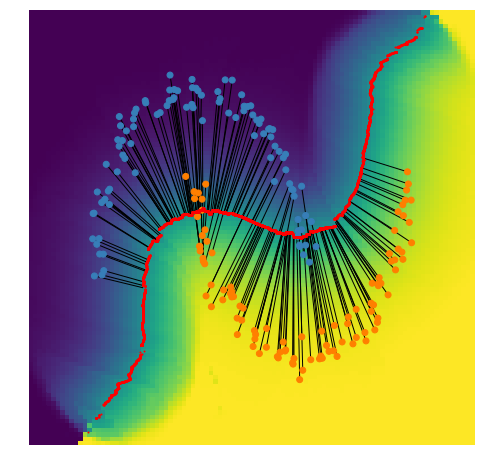

In [64]:
fig = plt.figure()
plt.pcolormesh(dense_grid[0], dense_grid[1], grid_probas.reshape(dense_grid_N,dense_grid_N),
    vmin=0, vmax=1)
for j in range(X.shape[0]):
    plt.plot(np.stack((X[j,0],y[j,0])), np.stack((X[j,1],y[j,1])), c='k',linewidth=1)
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=[CB_color_cycle[i] for i in c],zorder=10000)
plt.scatter(scms_y[:,0], scms_y[:,1], c='r', s=1,zorder=10000)

#plt.quiver(scms_X[:,0], scms_X[:,1], scms_y[:,0] - scms_X[:,0], scms_y[:,1]-scms_X[:,1], scale=1, scale_units="xy")
plt.xlim(*data_ranges[0])
plt.ylim(*data_ranges[1])
plt.axis('off')
plt.savefig(os.path.join(project_dir, "ortho_preds.png"), bbox_inches="tight")


#plt.title("iteration: {:05d}.{:05d}".format(newton,i))
#plt.savefig(os.path.join(scmsnewtondir, "svc_moons_{:05d}.png".format(newton*len(test[0]) + i)))

In [65]:
def nonorthopred_transformator(m,q,x,y,w):
    scores = m.decision_function(x)
    preds = m.predict(x)
    regularizer_features = scores*(preds*2-1)
    regularizer = sklearn.linear_model.LogisticRegression(C=3e-1, fit_intercept=False)
    regularizer.fit(regularizer_features.reshape(-1,1), y, sample_weight=w)
    q_input = m.decision_function(q.reshape(1,-1))*(2*m.predict(q.reshape(1,-1))-1)
    return regularizer.predict_proba(q_input.reshape(-1,1))
    
grid_nonorthopreds = linear_models.transform(scms_X, kernel=kernel, r=kernel.support_radius(), weighted=True,
    model_postprocessor=nonorthopred_transformator)

In [66]:
grid_nonorthopreds.shape

(10000, 2)

In [67]:
np.min(grid_nonorthopreds[:,1])

0.08596894106860911

In [68]:
np.max(grid_nonorthopreds[:,1])

0.9170879595935795

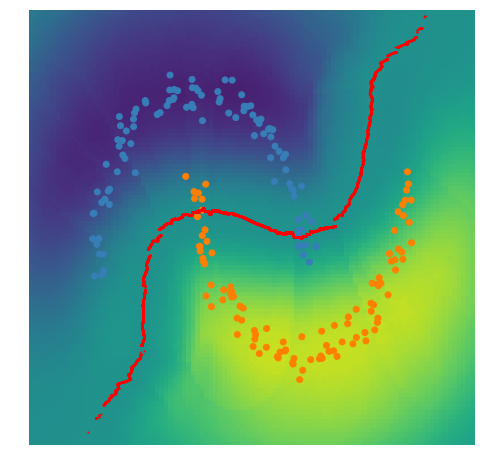

In [69]:
fig = plt.figure()
plt.pcolormesh(dense_grid[0], dense_grid[1], grid_nonorthopreds[:,1].reshape(dense_grid_N,dense_grid_N),
    vmin=0, vmax=1)
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=[CB_color_cycle[i] for i in c],zorder=10000)
plt.scatter(scms_y[:,0], scms_y[:,1], c='r', s=1,zorder=10000)

#plt.quiver(scms_X[:,0], scms_X[:,1], scms_y[:,0] - scms_X[:,0], scms_y[:,1]-scms_X[:,1], scale=1, scale_units="xy")
plt.xlim(*data_ranges[0])
plt.ylim(*data_ranges[1])
plt.axis('off')
plt.savefig(os.path.join(project_dir, "nonortho_preds.png"), bbox_inches="tight")


In [70]:
def check_normal_vectors(pts_on_decision_surface, normals):
    N = 5
    bt = sklearn.neighbors.BallTree(pts_on_decision_surface)
    # for each point, get the N nearest neighbors.  These points should approx define a plane.
    # If the points are sufficiently dense, then this line approaches the normal vector
    neighbors = bt.query(pts_on_decision_surface, k=N, return_distance=False)
    model = local_models.TLS_models.LinearODR_mD(m=1, invert=True)
    cos_dists = []
    for i, normal in enumerate(normals):
        neighborhood = neighbors[i]
        neighborhood_pts = pts_on_decision_surface[neighborhood]
        model.fit(neighborhood_pts)
        estimated_normal = model.coef_/np.linalg.norm(model.coef_)
        cos_dist = np.dot(normal/np.linalg.norm(normal), estimated_normal)
        cos_dists.append(cos_dist[0])
    return cos_dists

In [71]:
cos_dists = check_normal_vectors(scms_y, scms_normals)

In [72]:
cos_dists, np.max((1-np.abs(cos_dists))), np.mean(np.abs(cos_dists))

([-0.9999994974665753,
  -0.9999916444199771,
  -0.9999999710103118,
  -0.9999999994500118,
  -0.9999907933427793,
  -0.9999998456543961,
  -0.9997919941611437,
  -0.9999875355521729,
  -0.9999491410457992,
  -0.9999832656520907,
  -0.9999890618869094,
  -0.8543180772875818,
  -0.9999999221502238,
  -0.22341151240832857,
  -0.9999916757522826,
  -0.19095975994580344,
  0.4962831780344841,
  -0.9999998931485797,
  -0.8529911931164365,
  -0.9993864067126224,
  -0.7141636156546558,
  -0.7962893924835197,
  -0.9181510245671214,
  -0.9999372001076748,
  -0.9836933778986464,
  -0.7883046224523648,
  -0.9995007706456596,
  -0.9999874777183367,
  -0.6465328916261328,
  -0.9999154206442809,
  -0.8663595008073999,
  -0.7970595654702778,
  -0.8520439655984824,
  -0.05021796927110811,
  -0.6470505926093925,
  -0.9999506662563221,
  -0.9999556213601967,
  -0.9999941382005886,
  -0.9994011928151341,
  -0.9999892973745791,
  -0.9999962042956848,
  -0.999980405618817,
  -0.9999995711522489,
  -0.99990

(array([8138.,  704.,  308.,  128.,  222.,  169.,  133.,  142.,   42.,
          14.]),
 array([-1.        , -0.80893794, -0.61787588, -0.42681382, -0.23575176,
        -0.04468971,  0.14637235,  0.33743441,  0.52849647,  0.71955853,
         0.91062059]),
 <a list of 10 Patch objects>)

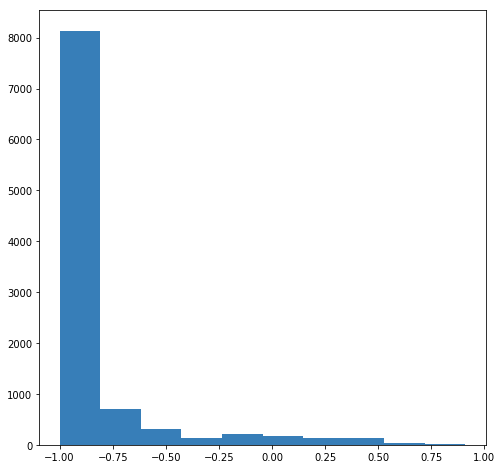

In [73]:
plt.hist(cos_dists)

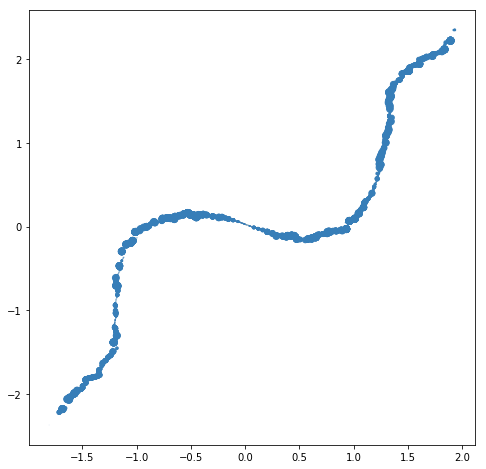

In [74]:
plt.scatter(scms_y[:,0], scms_y[:,1], s=50*(1-np.abs(cos_dists)))

In [75]:
main_line_pts = (
    (scms_y[:,1] < np.max(noisy_moons[:,1])) &
    (scms_y[:,1] > np.min(noisy_moons[:,1])) & 
    (scms_y[:,0] < np.max(noisy_moons[:,0])) &
    (scms_y[:,0] > np.min(noisy_moons[:,0])))

In [76]:
main_line_cos_dists = check_normal_vectors(scms_y[main_line_pts], scms_normals[main_line_pts])

(array([7888.,  419.,  196.,  111.,  201.,  112.,  124.,  142.,   42.,
          14.]),
 array([-1.        , -0.80893794, -0.61787588, -0.42681382, -0.23575176,
        -0.04468971,  0.14637235,  0.33743441,  0.52849647,  0.71955853,
         0.91062059]),
 <a list of 10 Patch objects>)

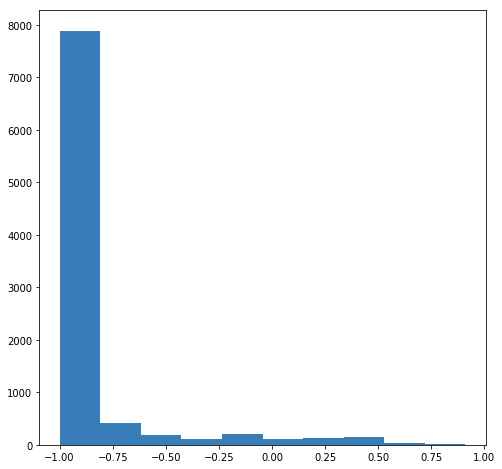

In [77]:
plt.hist(main_line_cos_dists)

In [78]:
np.mean(np.abs(main_line_cos_dists)), np.std(np.abs(main_line_cos_dists))

(0.9109790208943811, 0.2159508293125336)

In [86]:
np.quantile(np.abs(main_line_cos_dists), 0.2)

0.9435730848017485

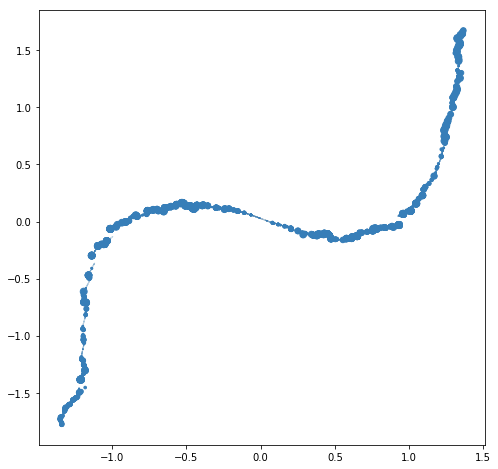

In [80]:
plt.scatter(scms_y[:,0][main_line_pts], scms_y[:,1][main_line_pts], s=50*(1-np.abs(main_line_cos_dists)))

In [81]:
normals

array([[[ 2.55564262e-01, -9.66792071e-01]],

       [[-2.19812625e-01, -9.75542111e-01]],

       [[-2.61695007e-01, -9.65150622e-01]],

       [[ 1.16047192e-01, -9.93243701e-01]],

       [[ 7.50880716e-01, -6.60437847e-01]],

       [[ 9.40975561e-01, -3.38474509e-01]],

       [[ 9.14703214e-01, -4.04126256e-01]],

       [[ 2.24197138e-01, -9.74543813e-01]],

       [[-3.39525236e-01, -9.40596946e-01]],

       [[ 4.06212560e-01, -9.13778614e-01]],

       [[ 3.57101496e-01, -9.34065587e-01]],

       [[-4.15638302e-01, -9.09529990e-01]],

       [[ 4.61718332e-02, -9.98933512e-01]],

       [[ 7.85802414e-01, -6.18477620e-01]],

       [[ 3.76144981e-02, -9.99292324e-01]],

       [[-4.34531298e-01, -9.00656733e-01]],

       [[ 1.99624224e-01, -9.79872527e-01]],

       [[-2.50827221e-01, -9.68031872e-01]],

       [[-2.57223906e-01, -9.66351832e-01]],

       [[ 2.55551523e-01, -9.66795438e-01]],

       [[ 9.36092635e-02, -9.95609013e-01]],

       [[-3.57961381e-01, -9.33736

In [82]:
_, last_models = linear_models.transform(test[30][-1][0], kernel=kernel, weighted=True, r=kernel.support_radius(), return_models=True)

IndexError: list index out of range

In [ ]:
len(last_models)

In [ ]:
train_preds = np.zeros((noisy_moons.shape[0],))
for i in range(noisy_moons.shape[0]):
    train_preds[i] = last_models[i].predict(noisy_moons[i:i+1])

In [ ]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=[CB_color_cycle[i] for i in train_preds.astype(int)], s=20*np.sum((noisy_moons-test[30][-1][0])**2, axis=-1))

In [ ]:
platt_regularizer = sklearn.linear_model.LogisticRegression(C=3e-1)

In [ ]:
train_preds.shape

In [ ]:
(np.sqrt(np.sum((noisy_moons-test[30][-1][0])**2, axis=1))*(train_preds*2-1)).reshape(-1,1)

In [ ]:
platt_regularizer.fit((np.sqrt(np.sum((noisy_moons-test[30][-1][0])**2, axis=1))*(train_preds*2-1)).reshape(-1,1), c)

In [ ]:
np.sum((noisy_moons-test[30][-1][0])**2, axis=1).shape

In [ ]:
probas = platt_regularizer.predict_proba((np.sqrt(np.sum((noisy_moons-test[30][-1][0])**2, axis=1))*(train_preds*2-1)).reshape(-1,1))

In [ ]:
probas

In [ ]:
plt.scatter((np.sqrt(np.sum((noisy_moons-test[30][-1][0])**2, axis=1))*(train_preds*2-1)), c)
plt.plot(np.linspace(-1,1,100), platt_regularizer.predict_proba(np.linspace(-1,1,100).reshape(-1,1))[:,1], c='r')

In [ ]:
list(map(tuple, np.stack((np.arange(c.shape[0]), train_preds.astype(int)))))

In [ ]:
probas[list(map(tuple, np.stack((np.arange(c.shape[0]), train_preds.astype(int)))))].shape

In [ ]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1], c=[CB_color_cycle[i] for i in train_preds.astype(int)], s=5*probas[list(map(tuple, np.stack((np.arange(c.shape[0]), train_preds.astype(int)))))])